In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN, tcn_full_summary

# Abnormality Detection

The goal of this notebook is to explore abnormality detection with a Temporal Convolutional Network

5.574463387940385
1.6787571791937694
-0.7575391106615263
5


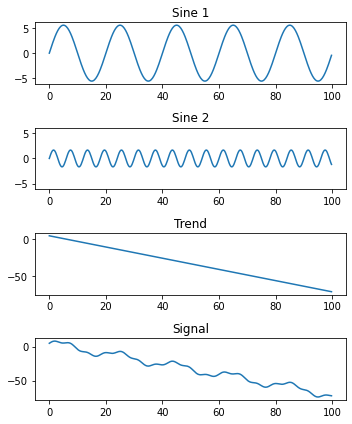

In [127]:
class SequenceGenerator():
    """
    This class will handle generating cyclic data and generating abnormal data. 
    """
    
    #Initialize random parameters that define the sequence
    def  __init__(self):
        
        #Define signal parameters
        self.sin1 = abs(np.random.randn()) + np.random.randint(low=5, high=10)
        self.sin2 = abs(np.random.randn()) + np.random.randint(low=1, high=3)
        self.trend = np.random.randn()/2
        self.offset = np.random.randint(low=0, high=30)
    
    #Generate a single sequence of data
    def generator(self):
        
        #Generate time data
        
        #Calculate signal and trend values
        
        #Combine signals and noise to create a sequence
        
        pass
    
    #Generate an abnormal sequence and mark the start and stop point
    def abnormality(self):
        
        #Generate a standard sequence
        
        #Select a random interval to intervene and add an abnormality
        
        #Generate abnormality in its place
        pass
    
        
    
    #Generate a train set
    def train_set(self, NUMBER):
        
        #Run generator NUMBER times and return signal
        pass
    
    #Visualize the trends, seasonality, and noise
    def visualize(self):
        
        #Generate time data
        t = np.arange(0, 100, 0.25)
             
        #plot sin1
        plt.figure(1, figsize=(5,6))
        ax1 = plt.subplot(411)
        sin1 = self.sin1 * np.sin(np.pi / 10 * t)
        plt.plot(t,sin1)
        plt.title("Sine 1")
        
        #plot sin2
        ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
        sin2 = self.sin2 * np.sin(np.pi / 3 * t)
        plt.plot(t, sin2)
        plt.title("Sine 2")
        
        #plot trend
        ax3 = plt.subplot(413, sharex=ax1)
        trend = (self.trend * t) + self.offset
        plt.plot(t, trend)
        plt.title("Trend")
        
        #plot all
        ax4 = plt.subplot(414, sharex=ax1)
        signal = sin1 + sin2 + trend
        plt.plot(t, signal)
        plt.title("Signal")
        plt.tight_layout()
        pass
    
    
SequenceGenerator = SequenceGenerator()
print(SequenceGenerator.sin1)
print(SequenceGenerator.sin2)
print(SequenceGenerator.trend)
print(SequenceGenerator.offset)

SequenceGenerator.visualize()